In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

from heatmapcluster import heatmapcluster

CPU times: user 1.1 s, sys: 335 ms, total: 1.44 s
Wall time: 2.28 s


In [2]:
tree = uproot.open("Run9goodDataQ_dualgate")["tree"]
energy = tree.array("Energy")
print(tree)
del tree
energy = energy[:,1]

label = np.load("label.npy")
label2 = np.load("label_4.npy")
survives = np.load("survives.npy")
final = np.load("final.npy")
final_final = np.load("final_final.npy")
really_final = np.load("really_final.npy")

energy1 = energy[label==4]
energy2 = energy1[label2==1]
energy3 = energy2[survives==0]
energy4 = energy3[final==1]
energy5 = energy4[final_final==1]
energy6 = energy5[really_final==1]

<TTree b'tree' at 0x00011929df60>


IndexError: boolean index did not match indexed array along dimension 0; dimension is 5145 but corresponding boolean dimension is 65675

In [ ]:
plt.hist(energy,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(energy1,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(energy2,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(energy3,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(energy4,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(energy5,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(energy6,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
print(len(dataset))
n_batches = int(len(dataset)/BATCH_SIZE) 

In [3]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 64, kernel_size=4, stride=2, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=2)
        self.cv2 = nn.Conv1d(64, 32, kernel_size=4, stride=2, padding=4)
        self.pl2 = nn.MaxPool1d(2, stride=2)
        self.cv31 = nn.Conv1d(32, 8, kernel_size=4, stride=2, padding=4)
        self.pl31 = nn.MaxPool1d(2, stride=2)
        self.cv32 = nn.Conv1d(32, 8, kernel_size=4, stride=2, padding=4)
        self.pl32 = nn.MaxPool1d(2, stride=2)
                
        self.ct1 = nn.ConvTranspose1d(8, 32, kernel_size=4, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=4, stride=2, padding=1)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        h2 = F.tanh(self.pl2(self.cv2(h1)))
        return self.pl31(self.cv31(h2)), self.pl32(self.cv32(h2))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
print("Autoencoder")

GEN = Autoencoder()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv2): Conv1d(64, 32, kernel_size=(4,), stride=(2,), padding=(4,))
  (pl2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv31): Conv1d(32, 8, kernel_size=(4,), stride=(2,), padding=(4,))
  (pl31): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv32): Conv1d(32, 8, kernel_size=(4,), stride=(2,), padding=(4,))
  (pl32): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(8, 32, kernel_size=(4,), stride=(4,), padding=(2,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(32, 32, kernel_size=(4,), stride=(2,), padding=(1,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 1, kernel_size=(4,), stride=(2,), padding=(1,))
)
torch.Size([64, 1, 4])
torch.Siz

In [4]:
GEN.load_state_dict(torch.load("Ultimatum.pkl"))

In [11]:
TEST = GEN(Variable(torch.randn(100,1,4096)))
# DATA = TEST[0].reshape(BATCH_SIZE,1,-1)
print(TEST[0].size())
print(TEST[1].size())
# print(DATA.size())
print(TEST[2].size())

torch.Size([100, 1, 4096])
torch.Size([100, 8, 65])
torch.Size([100, 8, 65])


In [ ]:
train_loader = DataLoader(dataset=np.load("train.npy"),
                         batch_size=1000,
                         shuffle=True,
                         num_workers=3)

In [ ]:
n_batches = int(len(np.load("train.npy"))/1000) 

In [ ]:
%%time
N_EPOCHS = 20
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        for batch_number, waveform in enumerate(train_loader):
            
#             print("epoch=",epoch)
#             print(batch_number)
#             print(waveform.size(),label.size())
    
            batch_size = waveform.size()[0]
            training_data = waveform.view(batch_size,1,4096)
            target = training_data
            
#             print(training_data,target)
            
            outputs = GEN(training_data)
#             print(outputs, target.view(-1).long())
            
#             print(outputs[0].size())
#             print(training_data.size())
            loss = criterion(outputs[0], target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            if (batch_number +1)%5 == 0:
                print("Epoch[%d/%d], Step[%d/%d], loss=%.6f"
                      %(epoch+1,
                        N_EPOCHS,
                        batch_number+1,
                        n_batches,
                        loss.data[0] ))
            
except KeyboardInterrupt:
    print('Training ended early.')
    
torch.save(GEN.state_dict(),"Ultimatum.pkl")

# ALL
random

In [5]:
%%time
class Waveform():
    
    def __init__(self, path=None):
        if path is None:
            raise ValueError("Insert file path!")
#         if no_classes is None:
#             raise ValueError("Number of classes?")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]
#         number = 
        label = np.load("label.npy")
        label2 = np.load("label_4.npy")
        survives = np.load("survives.npy")
        final = np.load("final.npy")
        final_final = np.load("final_final.npy")
        really_final = np.load("really_final.npy")

        # random labelling(test purposes)
        waveform_n = normalize(pmtall,axis=1,norm="l2")
        del pmtall,tree,pedestal,pedestal_sum
        waveform_f = waveform_n[label==4]
        waveform_f = waveform_f[label2==1]
        waveform_f = waveform_f[survives==0]
        waveform_f = waveform_f[final==1]
        waveform_f = waveform_f[final_final==1]
        self.waveform = waveform_f[really_final==1]
        del waveform_n,waveform_f
#         self.label = np.random.randint(3,size=(len(pmtall),))
    
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]



CPU times: user 40 µs, sys: 1e+03 ns, total: 41 µs
Wall time: 46 µs


# reduced from all

In [6]:
%%time
class Waveform():
    
    def __init__(self, path=None):
        if path is None:
            raise ValueError("Insert file path!")
#         if no_classes is None:
#             raise ValueError("Number of classes?")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]
#         number = 
        
        # random labelling(test purposes)
        self.waveform = normalize(pmtall,axis=1,norm="l2")
#         self.label = np.random.randint(3,size=(len(pmtall),))
    
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]



CPU times: user 42 µs, sys: 1e+03 ns, total: 43 µs
Wall time: 47.9 µs


In [7]:
dataset = Waveform(path="../Run9goodDataQ_dualgate.root.root")
print(len(dataset))

5145


In [8]:
BATCH_SIZE = 5150
data_loader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=3) 

In [10]:
def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

# Encoder convolution features

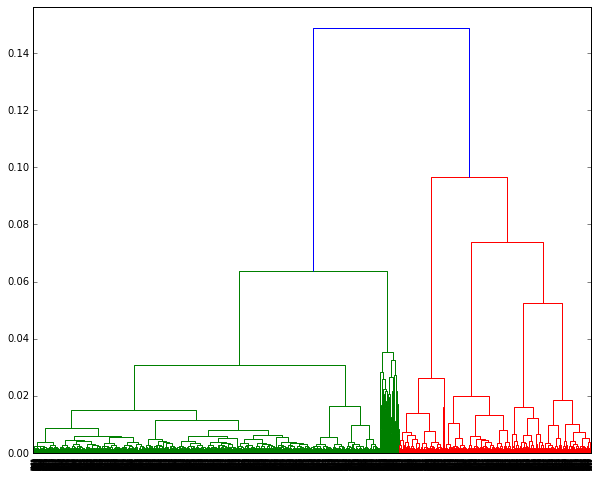

[1 2 3 4 5 6 7 8 9]


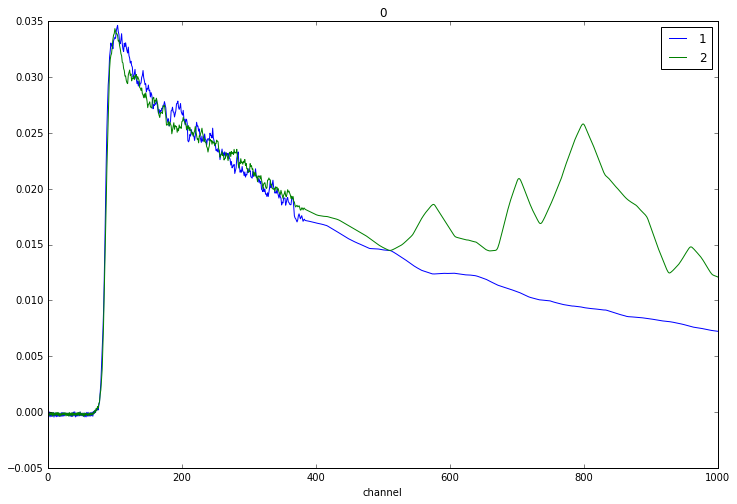

CPU times: user 54.4 s, sys: 12.9 s, total: 1min 7s
Wall time: 1min 6s


In [13]:
%%time

selector = np.empty(5145)

try:
    for batch_number, waveform in enumerate(data_loader):
        average = []
        average2 = []
        average3 = []
        average4 = []

        batch_size = waveform.size()[0]
#         print(batch_size)
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        features = GEN.encoder(waveform_in)
        
        green = np.reshape(features[0].detach().numpy(),(batch_size,-1))
        Z = linkage(green, method="ward")

        fig = plt.figure(figsize=(10, 8))
        dn = dendrogram(Z)
        plt.show()
        
        clusters = fcluster(Z, 0.03, criterion='distance')
        print(np.unique(clusters))
        selector = clusters
        
        for i, waveform_out in enumerate(features[0]):
            
            blue = waveform_in[i].detach().numpy()
#             if clusters[i]==4:
#                 plt.figure()
#                 plt.plot(waveform[i])
#                 plt.show()

            if clusters[i]==4:
                average.append(blue[0])
                
            if clusters[i]==3:
                average2.append(blue[0])
            
#             if clusters[i]==3:
#                 average3.append(blue[0])
                
#             if clusters[i]==4:
#                 average4.append(blue[0])
        dang = np.mean(average, axis=0)
        dang2 = np.mean(average2, axis=0)
#         dang3 = np.mean(average3, axis=0)
#         dang4 = np.mean(average4, axis=0)
        
        plt.figure(figsize=(12,8))
        plt.plot(dang,label="1")
        plt.plot(dang2,label="2")
#         plt.plot(dang3,label="3")
#         plt.plot(dang4,label="4")
        plt.xlim(0,1000)
        plt.xlabel("channel")
        plt.legend()
        plt.title(batch_number)
        plt.show()
                    
#         Features[batch_number*1000:(batch_number+1)*1000] = feat[0]
        
        
#         print(Features.size())
    # db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
    # print(db.core_sample_indices_)
    # print(db.labels_)
        

except KeyboardInterrupt:
    print('Training ended early.')

# Waveform

(4500, 4096)
(4499, 4)


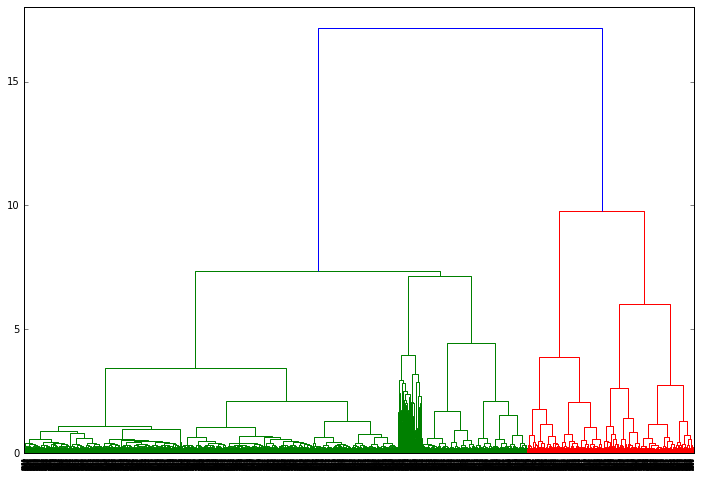

(4500,)
[1 1 5 ... 1 2 1]
[1 2 3 4 5 6]


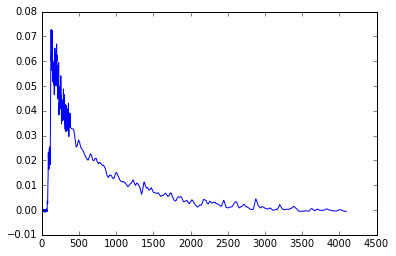

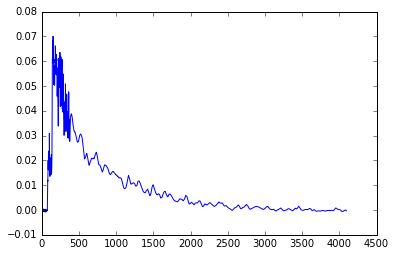

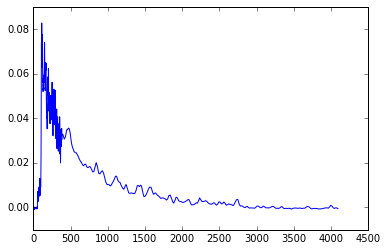

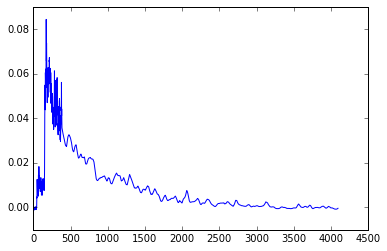

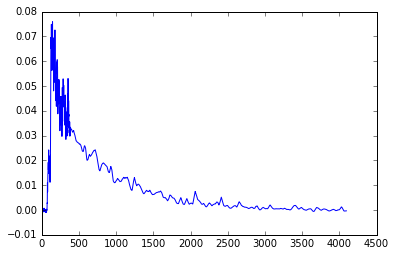

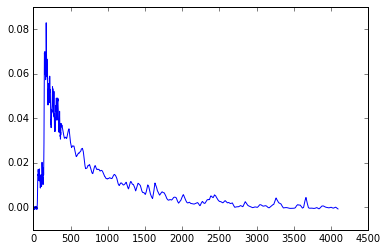

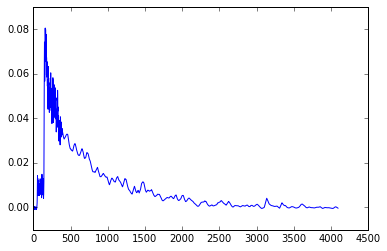

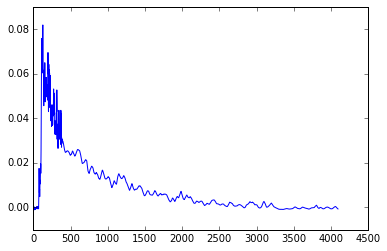

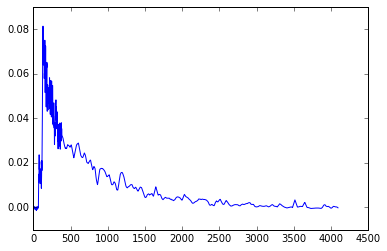

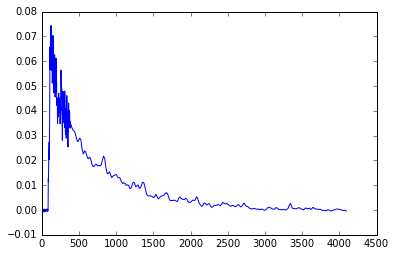

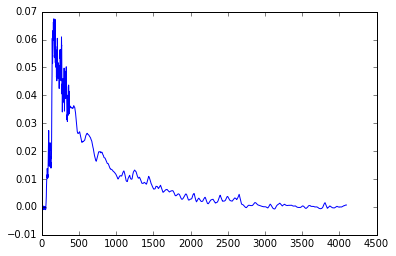

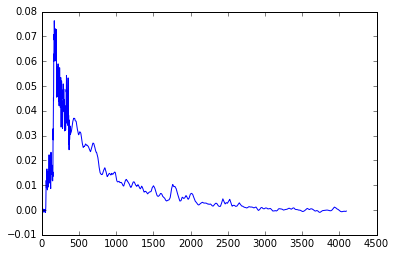

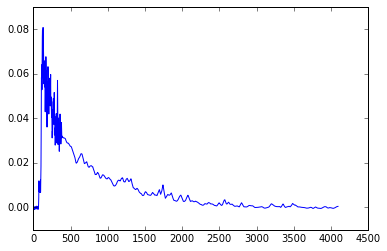

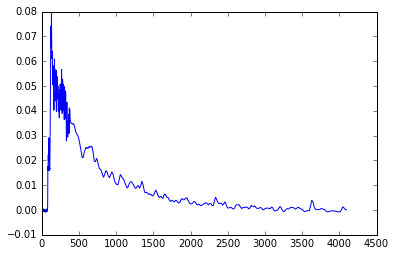

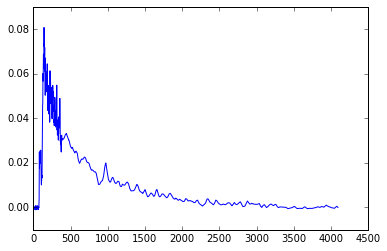

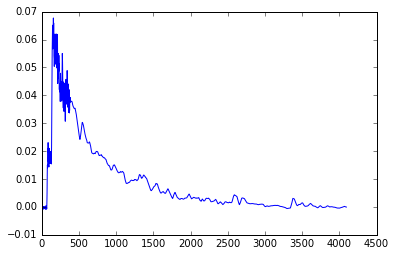

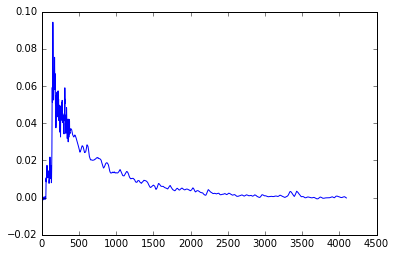

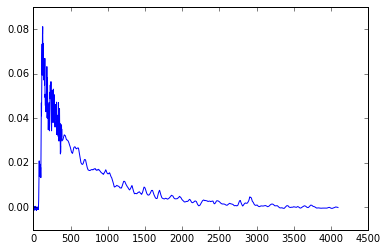

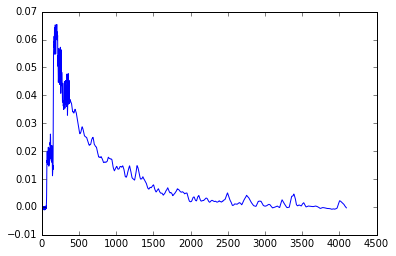

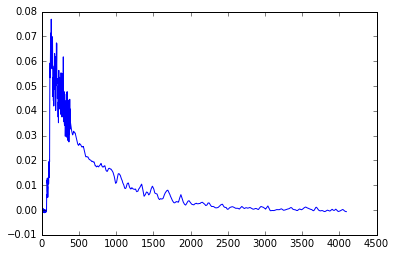

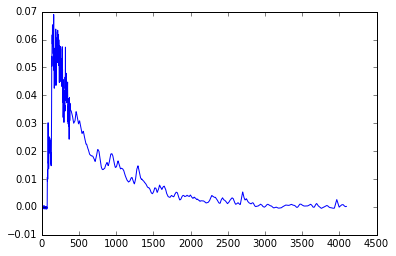

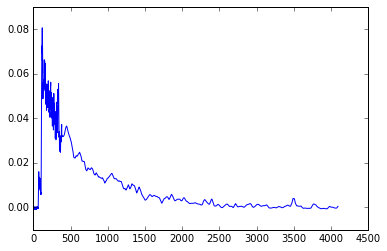

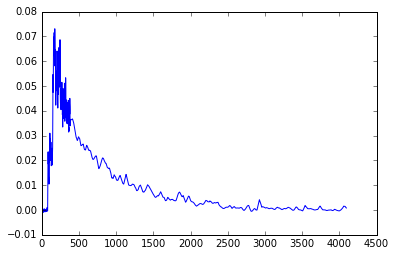

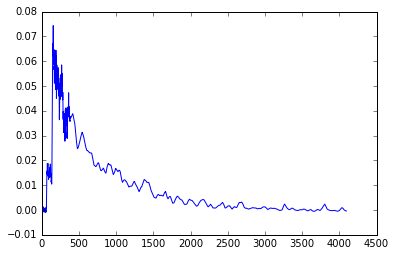

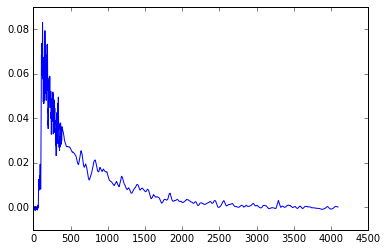

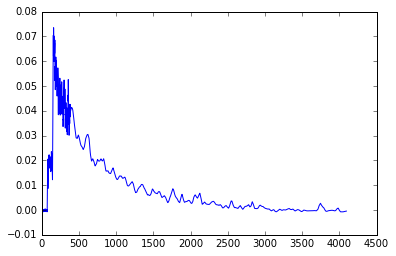

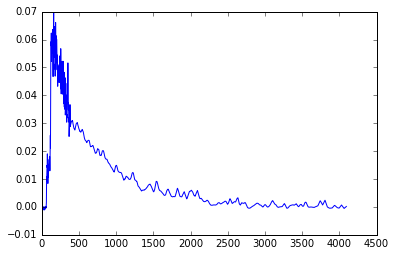

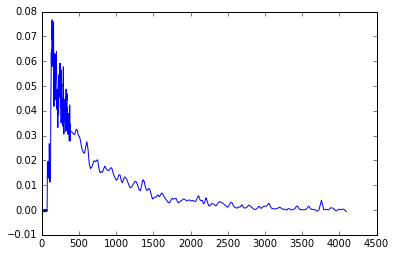

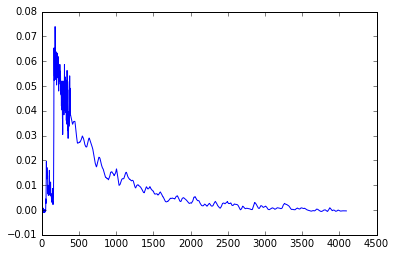

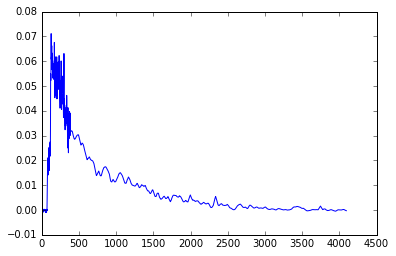

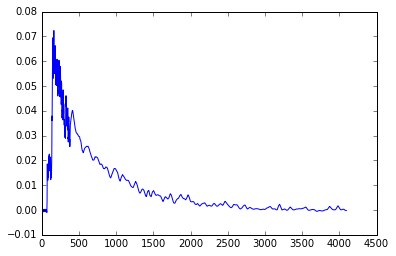

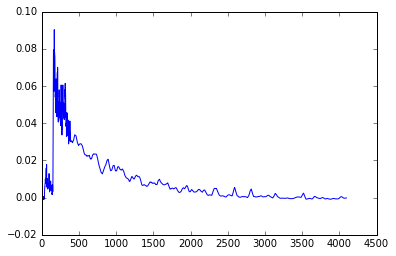

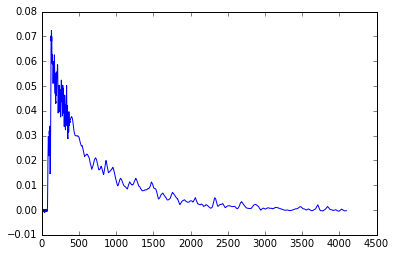

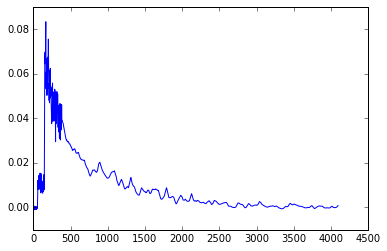

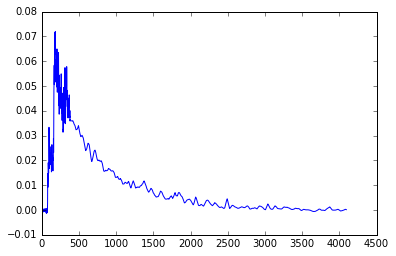

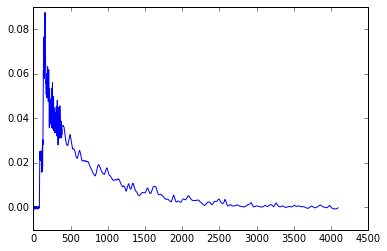

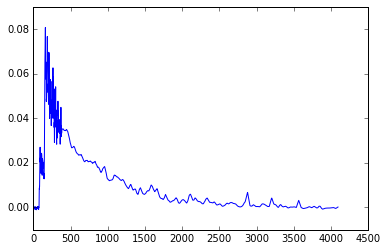

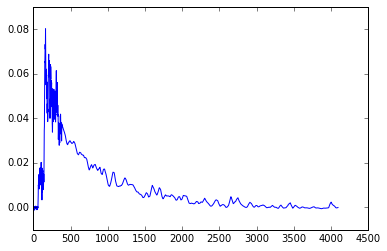

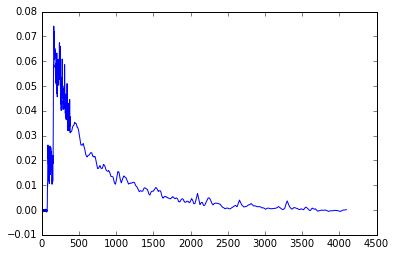

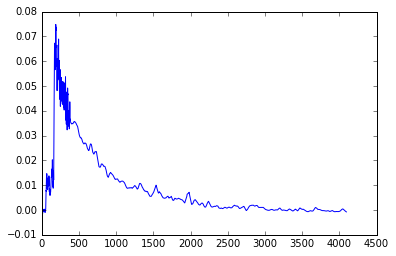

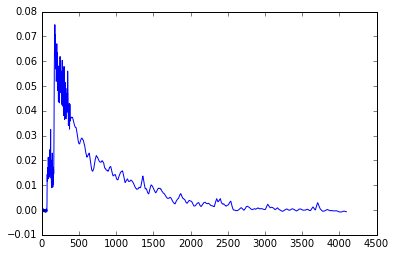

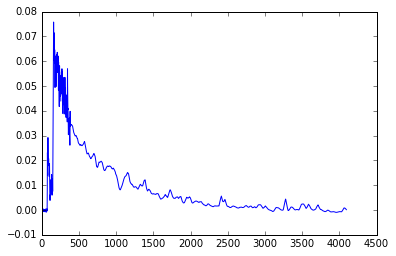

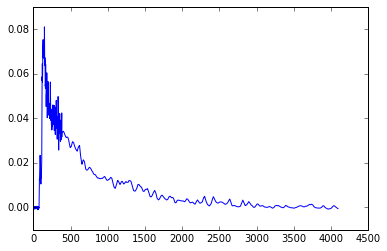

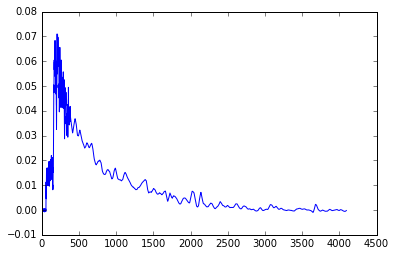

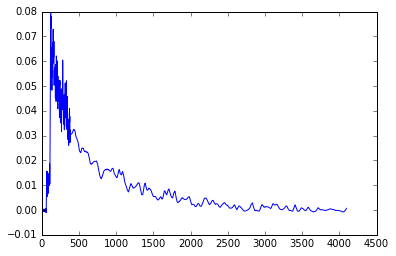

Training ended early.


Process Process-29:
Process Process-28:
Process Process-30:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/tor

In [22]:
try:
    for batch_number, waveform in enumerate(data_loader):

        if batch_number == 1:
            break
        batch_size = waveform.size()[0]
        green = np.reshape(waveform.detach().numpy(),(batch_size,-1))
        print(green.shape)
        Z = linkage(green, method="ward")
        print(Z.shape)
#         print(Z)
        fig = plt.figure(figsize=(12, 8))
        dn = dendrogram(Z)
        plt.show()
        
        clusters = fcluster(Z, 5, criterion='distance')
        print(clusters.shape)
        print(clusters)
        print(np.unique(clusters))
        
        for i, waveform_i in enumerate(waveform):
#             if clusters[i]==3:
#                 plt.figure()
#                 plt.plot(waveform[i])
#                 plt.show()
#             if clusters[i]==1:
#                 un1.append(green[i])
                
#             if clusters[i]==2:
#                 un2.append(green[i])
                
except KeyboardInterrupt:
    print('Training ended early.')

In [20]:
print(selector)
np.save("selector_psd",selector)

[1 2 8 ... 9 2 1]
